In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [3]:
!pip install astroML

     ---------------------------------------- 0.0/134.3 kB ? eta -:--:--
     -------------------------------------- 134.3/134.3 kB 3.9 MB/s eta 0:00:00


In [4]:
from astroML.datasets import fetch_rrlyrae_mags

data = fetch_rrlyrae_mags()
# number of objects in dataset

data = data.byteswap().newbyteorder()

df = pd.DataFrame(data)
df.head()

[========================================]  78.8kb / 78.8kb   


,__SIG2010_,Type,Per,uAmp,T0_u,gAmp,T0_g,rAmp,T0_r,iAmp,...,RAJ2000,DEJ2000,Ar,Dist,umag,gmag,rmag,imag,zmag,Vmag
0,4099,b'ab',0.641754,0.534608,51075.274714,0.563839,51075.288902,0.398326,51075.295112,0.317851,...,0.935679,1.115859,0.089,17.750000,18.134001,16.989000,16.777000,16.702999,16.684999,16.846001
1,13350,b'ab',0.547987,1.029445,54025.330112,1.093322,54025.326856,0.801720,54025.326474,0.642111,...,0.283437,1.178522,0.080,24.770000,18.839001,17.679001,17.544001,17.497000,17.500999,17.570000
2,15927,b'ab',0.612263,0.651579,53680.222485,0.697439,53680.229439,0.486554,53680.226214,0.368674,...,3.254658,-0.584066,0.090,29.120001,19.288000,18.058001,17.858999,17.792000,17.780001,17.921000
3,20406,b'ab',0.631853,0.553247,54000.280528,0.586784,54000.292109,0.426846,54000.276631,0.342734,...,3.244369,0.218891,0.088,9.130000,16.715000,15.543000,15.336000,15.286000,15.276000,15.403000
4,21992,b'ab',0.625880,1.109322,53698.245218,1.139930,53698.245256,0.849551,53698.243534,0.661144,...,4.315354,1.054582,0.077,7.350000,16.186001,15.040000,14.909000,14.864000,14.853000,14.932000


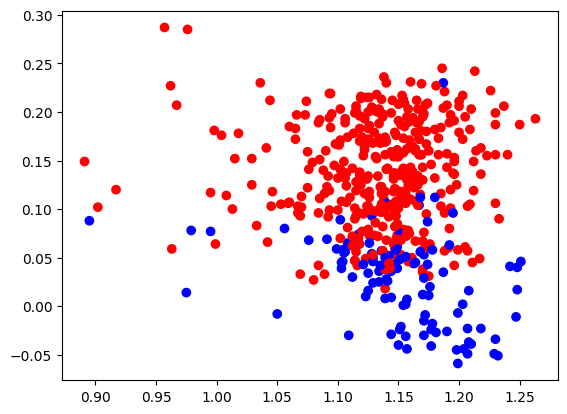

In [5]:
df['u-g'] = df['umag'] - df['gmag']
df['g-r'] = df['gmag'] - df['rmag']
df['r-i'] = df['rmag'] - df['imag']
df['i-z'] = df['imag'] - df['zmag']

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'))

In [14]:
def phi(A, u):
    return sum(u[i]*np.dot(A[i].T, A[i])for i in range(len(u))) - np.dot(sum(u[i]*A[i] for i in range(len(u))).T,sum(u[i]*A[i] for i in range(len(u))))

def e(idx):
    vec = np.zeros(len(A))
    vec[idx] = 1
    return vec

<img src="./away_step_pseudocode.png" alt="Alternative text" />

In [8]:
def LMO(gradient):
    lmo = np.argmin(gradient)
    return lmo

In [34]:
def vertex_computation(set_weights, gradient, dimension_m,
                                    local_FW=False):
    weight_indexes = np.where(set_weights > 0)[0]
    
    max_gradient_index = np.argmax(gradient[weight_indexes])
    v_index = weight_indexes[max_gradient_index]
    
    v = np.zeros(dimension_m)
    v[v_index] = 1.0
    return v, v_index

In [87]:
# 
def frankWolfe_AwayStep(A, epsilon, max_iterations=1000):
    
    # Logistic Tracking
    total_time = 0
    count_FrankWolfe = 0
    count_AwayStep = 0
    count_dropped = 0 # Is this appropriate/necessary?? ASK TEAM
    count_iterations = 0

    A_squared = 2 * np.matmul(A.T, A)
    Z = np.sum(np.square(A), axis=0)
    n, m = A.shape

    # initialize u vector
    u = np.zeros(n)
    u[0] = 1.0

    # Create set S that will contain u's across time steps
    S_set = np.zeros(n)
    S_set[np.where(u > 0)[0]] = 1
    # print("S_Set: ", S_set)

    for i in range(max_iterations):
        time_start = time.time()
        # At beginning b/c there is a break clause
        count_iterations += 1

        A_squared_u = np.matmul(A_squared.T, u)
        dual_val = phi(A, u)

        # Think about computing the dual function at each step to show how it changes

        # 
        gradient = A_squared_u - np.sum(np.square(A), axis=0)
        # print(i)
        # print(A_squared_u)
        # print(np.sum(np.square(A), axis=0))
        # print(gradient)
        
        # 
        s_index= LMO(gradient)
        s = np.zeros(n)
        s[s_index] = 1.0

        # Compute the direction of Frank-Wolfe
        direction_FrankWolfe = s - u
        
         # Away Step solution from Lac-Jul
        v, v_index = vertex_computation(S_set, gradient, n)

        # Compute the direciton of the Away-Step
        direction_AwayStep = u - v

        # If the Frank-Wolfe gap is less than the specified stopping condition, break the loop
        gap_FrankWolfe = -gradient.T @ direction_FrankWolfe
        # dual_gap_list.append(g_FW) # Used to track the gap list over time for plotting purposes REMOVE LATER

        if gap_FrankWolfe <= epsilon:
            comp_time = time.time() - time_start
            total_time = comp_time + total_time
            # CPU_time_list.append(total_time)
            # active_set_size_list.append(int(np.sum(np.abs(S_t) >= 0.0001))) # Used to track the active set size over time for plotting purposes
            break

        # Compare the Frank-Wofle gap and Away-Step gap
        gap_AwayStep = -gradient.T @ direction_AwayStep 
        if gap_FrankWolfe >= gap_AwayStep:
            # Use the Frank-Wolfe direction
            direction_chosen = direction_FrankWolfe
            max_alpha = 1  # Set max step-size
            frankwolfe_flag = True
        # Step 8 - Else
        else:
            # use the away-step direction
            direction_chosen = direction_AwayStep
            max_alpha = S_set[v_index] / (1 - S_set[v_index])
            frankwolfe_flag = False

        # compute the step-size using line search (Are we sticking to this?? CHECK LATER)
            # i is the iteration variable of this for loop
        # alpha = calculate_step_size(line_search_strategy, i, A_squared, u, Z, direction_chosen, gradient, max_alpha)
        alpha = 2 / (i + 1)
        alpha = max(0.0, min(alpha, max_alpha))

        # update u
        u = u + (alpha * direction_chosen)

        # Updating the set as described in Lacost-Jul
        if frankwolfe_flag:
            S_set = (1 - alpha) * S_set
            S_set[s_index] = S_set[s_index] + alpha
            # Exceptional case: Step-size of 1, this collapses the active set!
            if alpha > 1 - np.spacing(1):  # Take a full step
                S_set = np.zeros(n)
                S_set[s_index] = 1
            count_FrankWolfe += 1
        else:  # Away step used
            S_set = (1 + alpha) * S_set
            count_AwayStep += 1
            if abs(alpha - max_alpha) < 10 * np.spacing(1):  # Step is dropped
                count_dropped += 1
                S_set[v_index] = 0
            else:
                S_set[v_index] = S_set[v_index] - alpha
        # active_set_size_list.append(int(np.sum(np.abs(S_t) > 0))) # Used to track the active set size over time for plotting purposes\
        
        # for tracking the total time and time per iteration
        iteration_time = time.time() - time_start
        total_time = total_time + iteration_time
        # CPU_time_list.append(total_time) # Used to track the total time over time for plotting purposes REMOVE LATER??

    # After the iterations, compute the radius and center of the MEB
    radius = np.sqrt(-dual_val)
    center = np.matmul(A.T, u)
    # print("CENTER: ", center[-1])

    """
    logging.info("\n-----------Away step Frank Wolfe finished!--------------")
    logging.info(f"Center: {center} and Radius: {radius}")
    logging.info(f"Last value of dual function: {dual_t:.3e}")
    logging.info(f"Last value of FW gap: {dual_gap_t:.3e}")
    logging.info(f"Total CPU time: {total_time:.3e}")
    logging.info(f"Active set size: {active_set_size_list[-1]}")
    logging.info(f"Number of iterations: {len(dual_list)}")
    logging.info(f"FW steps: {number_FW}")
    logging.info(f"Away steps: {number_AW}")
    logging.info(f"Drop steps: {number_drop}")
    """

    # output = {
    #     "name": "asfw",
    #     "center": center,
    #     "radius": radius,
    #     "number_iterations": len(dual_list),
    #     "active_set_size_list": active_set_size_list,
    #     "dual_gap_list": dual_gap_list,
    #     "dual_list": dual_list,
    #     "CPU_time_list": CPU_time_list}

    # return output
    return center, radius, count_iterations, total_time, u

In [88]:
# we supply: A, epsilon, max_iterations=1000
A = df[df['Type']==b'ab'][['u-g', 'g-r']].values
print(A.shape)
epsilon = 0.001

center, radius, count_iterations, total_time, u = frankWolfe_AwayStep(A, epsilon, max_iterations=1000)

print("CENTER: ", center)
print("RADIUS: ", radius)
print("COUNT ITERATIONS: ", count_iterations)
print("TOTAL TIME: ", total_time)
print("U: ", u)



(379, 2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 379 is different from 2)

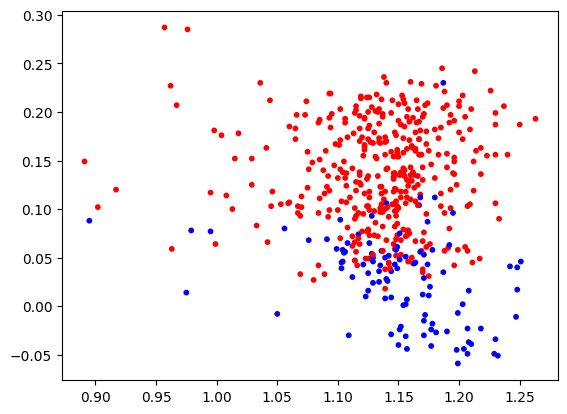

In [49]:
circle = plt.Circle(tuple(center), radius, color='g', fill=False)

# ax = plt.gca()
# ax.cla()

# ax.add_patch(circle)

plt.scatter(df['u-g'], df['g-r'], c=np.where(df['Type'] == b'ab', 'r', 'b'), s=10)